In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

/home/fberes/.conda/envs/ethsim/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dandelion example

In [3]:
net = Network(20, 4)

In [4]:
dp = DandelionProtocol(net, 0.1)

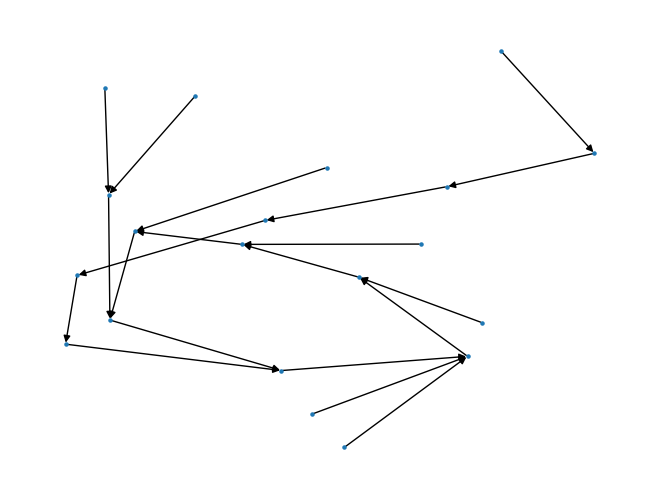

In [5]:
nx.draw(dp.line_graph, node_size=5)

In [6]:
adv = Adversary(net, 1/3)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run()

In [7]:
evaluator = Evaluator(sim)
report = evaluator.get_report()
report

{'hit_ratio': 0.7, 'mean_inverse_rank': 0.7272727272727273}

# Experiment example

In [8]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, int(network_size / 10), verbose=False)
    sim.run()
    evaluator = Evaluator(sim)
    report = evaluator.get_report()
    report["protocol"] = str(protocol)
    report["adversary_ratio"] = adv_ratio
    return report

In [9]:
network_size = 1000
degree = 50
num_trials = 10
adversary_ratios = [0.01,0.025,0.05,0.075,0.1]
results = []

In [10]:
%%time
# it could be parallelized
for adv_ratio in adversary_ratios:
    for _ in range(num_trials):
        # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
        net = Network(network_size, degree)
        adv = Adversary(net, adv_ratio)
        # BUT: messages won't be the same!!!
        results.append(run_and_eval(net, adv, BroadcastProtocol(net)))
        results.append(run_and_eval(net, adv, DandelionProtocol(net, 0.5)))
        results.append(run_and_eval(net, adv, DandelionProtocol(net, 0.25)))
    print(adv_ratio)

0.01
0.025
0.05
0.075
0.1
CPU times: user 7min 50s, sys: 2.23 s, total: 7min 53s
Wall time: 7min 53s


In [11]:
import seaborn as sns

In [12]:
results_df = pd.DataFrame(results)
results_df.head()

,hit_ratio,mean_inverse_rank,protocol,adversary_ratio
0,0.22,0.221557,BroadcastProtocol(),0.01
1,0.07,0.071856,DandelionProtocol(0.5000),0.01
2,0.04,0.041896,DandelionProtocol(0.2500),0.01
3,0.21,0.211577,BroadcastProtocol(),0.01
4,0.11,0.111776,DandelionProtocol(0.5000),0.01


<AxesSubplot: xlabel='adversary_ratio', ylabel='hit_ratio'>

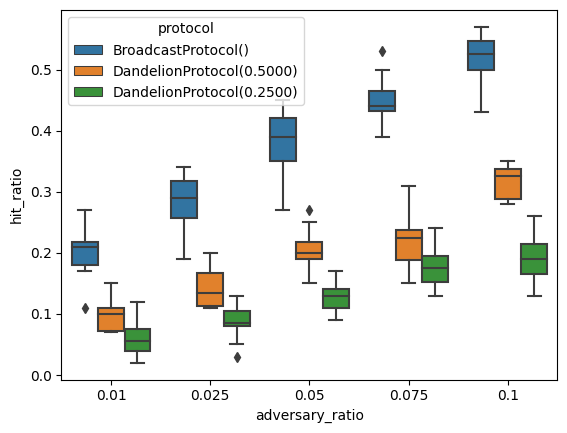

In [13]:
sns.boxplot(data=results_df, x="adversary_ratio", y="hit_ratio", hue="protocol")